In [79]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from FillBetween3D import fill_between_3d

In [4]:
df = pd.read_csv("./data/COMPOSED.csv")
countries = df["Country"]
X_0,X_1,X_2 = df["complex_HH"],df["complex_PUB"],df["complex_PRIV"]

Text(0.5, 0, 'Z')

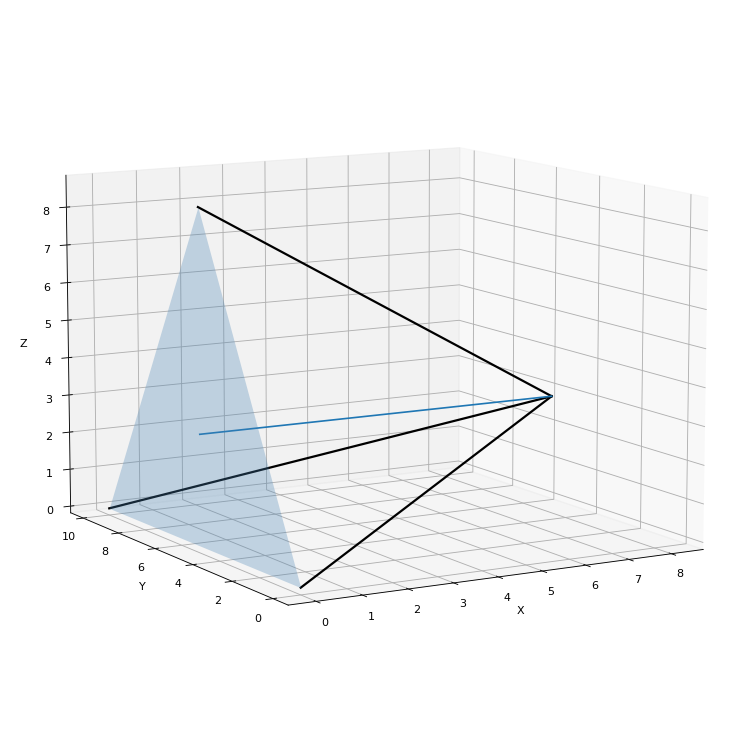

In [89]:
ax = plt.figure(figsize=(16,12),dpi=80).add_subplot(projection="3d")


# ===== 绘制正四面体 =====
edge_length = 10
vertexes = np.array([
    [0,0,0],
    [0,edge_length,0],
    [0,edge_length/2,edge_length/2*np.sqrt(3)],
    [np.sqrt(6)*edge_length/3,edge_length/2,edge_length/2/np.sqrt(3)]
])
bottom_center = np.array([0,edge_length/2,edge_length/2/np.sqrt(3)])

# list(zip(vertexes))
def getXYZ(type:str):
    XYZ_dict = dict(x=0,y=1,z=2)
    XYZ = XYZ_dict[type]
    return np.array(list(map(lambda x:x[XYZ],vertexes)))
Xes = getXYZ("x")
Yes = getXYZ("y")
Zes = getXYZ("z")

for i in range(3):
    ax.plot(Xes[[i,3]],Yes[[i,3]],Zes[[i,3]],c="k",lw=2)

Xes = np.append(Xes,bottom_center[0])
Yes = np.append(Yes,bottom_center[1])
Zes = np.append(Zes,bottom_center[2])

ax.plot(Xes[[4,3]],Yes[[4,3]],Zes[[4,3]],"--")

line1 = [Xes[[0,1]],Yes[[0,1]],Zes[[0,1]]]
line2 = [Xes[[0,2]],Yes[[0,2]],Zes[[0,2]]]
fill_between_3d(ax,*line1,*line2,mode=1,alpha=.3)



ax.view_init(10,-120)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# ax.set_axis_off() # 隐藏坐标轴